In [1]:
# Common imports

import sys
sys.path.append("../datasets/ARID_supporting_scripts")

import json
import mapper
import datasets
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
def load_jsonl(filename):
    
    jlines = []
    with open(filename, "r", encoding = "utf-8") as file:
        for line in file:
            line = line.strip()
            if line:
                jlines.append(json.loads(line)) 
                
    processed_jlines = []
    for item in jlines:
        processed_jline = {'id': item.get('id'), 'text': item.get('text'), 'label': item.get('label')}
        processed_jline['label'] = (lambda l: l[0] if isinstance(l, list) and len(l) > 0 else (l if not isinstance(l, list) else 'non_requirement_text'))(item.get('label'))
        processed_jlines.append(processed_jline)
        
    return processed_jlines

In [3]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

batch_size = 16

model_ckpt = '../ReqSeek/'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = TFAutoModelForSequenceClassification.from_pretrained(model_ckpt)

Metal device set to: Apple M4 Pro


2025-05-26 16:11:14.039347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 16:11:14.039461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at ../ReqSeek/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [4]:
label2id = model.config.label2id
id2label = model.config.id2label

In [5]:
def preprocess_function(dataset):
    return tokenizer(dataset['text'], truncation = True)

In [6]:
def forward_pass_with_label(batch):
    input_ids = batch['input_ids']
    attention_masks = batch['attention_mask']
    true_labels = tf.convert_to_tensor( batch['label'])
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, padding = "post")
    attention_masks = tf.keras.preprocessing.sequence.pad_sequences(attention_masks, padding = "post")
    with tf.GradientTape() as tape:
        output = model(input_ids, attention_masks)
        probas = tf.nn.softmax(output.logits, axis = -1).numpy()
        predicted_labels = tf.argmax(output.logits, axis = -1).numpy()
    
    return {"y_pred": mapper.twoClassMapper([id2label[lbl] for lbl in predicted_labels]), 
            "y_probas": [probas[i][predicted_labels[i]] for i in range(len(predicted_labels))]}

# Loading SRS 1: Software Requirements Specification (SRS) For the <Nodes Portal Toolkit (NPT)>

In [7]:
srs_1_path = "./three_real_world_srs/ntp/ntp_labeled.jsonl"
srs_1_requirements = load_jsonl(srs_1_path)
srs_1_requirements_hf = datasets.Dataset.from_list(srs_1_requirements)

In [8]:
srs_1_requirements_hf_encoded = srs_1_requirements_hf.map(preprocess_function, batched = True)
srs_1_requirements_hf_predicted = srs_1_requirements_hf_encoded.map(forward_pass_with_label, batched = True, batch_size = 8)

Map:   0%|          | 0/1065 [00:00<?, ? examples/s]

INFO:tensorflow:Assets written to: ram://f43d7cea-95b8-4374-9531-410b3d51dde6/assets


INFO:tensorflow:Assets written to: ram://f43d7cea-95b8-4374-9531-410b3d51dde6/assets


Map:   0%|          | 0/1065 [00:00<?, ? examples/s]

In [9]:
srs_1_requirements_hf_predicted.to_pandas()[:5]

,id,text,label,input_ids,attention_mask,y_pred,y_probas
0,108084,"See discussions, stats, and author profiles fo...",auxiliary,"[0, 19224, 4404, 6, 13076, 6, 8, 2730, 11729, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",auxiliary,0.995020
1,108085,Software Requirements Specification (SRS) for ...,auxiliary,"[0, 45752, 41333, 33534, 5000, 36, 104, 8105, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",auxiliary,0.997657
2,108086,Technical Report · September 2011,auxiliary,"[0, 43997, 2872, 13339, 772, 1466, 2]","[1, 1, 1, 1, 1, 1, 1]",auxiliary,0.991429
3,108087,"2 authors, including:",auxiliary,"[0, 176, 7601, 6, 217, 35, 2]","[1, 1, 1, 1, 1, 1, 1]",auxiliary,0.757307
4,108088,Université Libre de Bruxelles,auxiliary,"[0, 9685, 10744, 21193, 40514, 263, 11831, 117...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",auxiliary,0.991989


In [10]:
y_true_srs_1 = srs_1_requirements_hf_predicted['label']
y_pred_srs_1 = srs_1_requirements_hf_predicted['y_pred']

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate(y_true, y_pred, average = 'binary'):
    print('Precision: ', precision_score(y_true, y_pred, average = average))
    print('Recall: ', recall_score(y_true, y_pred, average = average))
    print('Recall: ', f1_score(y_true, y_pred, average = average))

In [12]:
evaluate(y_true_srs_1, y_pred_srs_1, average = 'macro')

Precision:  0.9401475966716772
Recall:  0.9842150837261388
Recall:  0.9604103936656629


In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels, ax):
    unique_labels = set(y_true).union(set(y_preds))
    if len(unique_labels) != len(labels):
        raise ValueError(f"The number of unique labels in y_true and y_preds is {len(unique_labels)}, but got {len(labels)} labels.")
    
    cm = confusion_matrix(y_true, y_preds, normalize="true", labels=list(unique_labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    ax.set_title("Normalized confusion matrix")
    ax.set_xticklabels(labels, rotation=90)

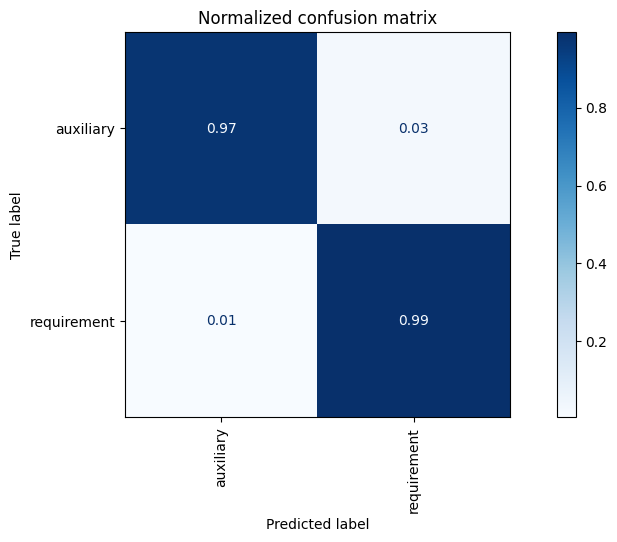

In [14]:
lables = np.unique(y_true_srs_1)
fig, ax = plt.subplots(figsize = (12, 5))
plot_confusion_matrix(y_pred_srs_1, y_true_srs_1, lables, ax)

In [15]:
idx = np.where(np.array(y_true_srs_1) != np.array(y_pred_srs_1))[0]
filtered_dataset = srs_1_requirements_hf_predicted.select(idx)
for idx, label, y_pred, y_proba, text in zip(filtered_dataset['id'], filtered_dataset['label'], filtered_dataset['y_pred'], filtered_dataset['y_probas'], filtered_dataset['text']):
    print('ID: ', idx)
    print('True Class: ', label)
    print('Predicted Class: ', y_pred)
    print('Probability: ', y_proba)
    print('Text: ', text)
    print('#' * 10)

ID:  108154
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9967625141143799
Text:  The NPT should enable the Node Managers to customize the way GBIF-compliant data are served to their own community or to a specific group of data users.
##########
ID:  108177
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9964426159858704
Text:  - Green: NPT V1.0 must have this feature
##########
ID:  108178
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9966327548027039
Text:  - Yellow: NPT V1.0 should have this feature if at all possible
##########
ID:  108194
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9961431622505188
Text:  This section lists the different actors NPT instances shall interact with: end users (primary actors) and actors from which the system needs assistance to satisfy a goal (secondary actors).
##########
ID:  108200
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.99675744

# Loading SRS 2: Software Requirements Specification Restaurant Menu & Ordering System

In [16]:
srs_2_path = "./three_real_world_srs/rmos/rmos_labeled.jsonl"
srs_2_requirements = load_jsonl(srs_2_path)
srs_2_requirements_hf = datasets.Dataset.from_list(srs_2_requirements)

In [17]:
srs_2_requirements_hf_encoded = srs_2_requirements_hf.map(preprocess_function, batched = True)
srs_2_requirements_hf_predicted = srs_2_requirements_hf_encoded.map(forward_pass_with_label, batched = True, batch_size = 8)

Map:   0%|          | 0/724 [00:00<?, ? examples/s]

INFO:tensorflow:Assets written to: ram://f18de5fc-0d53-4343-aa43-8473e54cfe6d/assets


INFO:tensorflow:Assets written to: ram://f18de5fc-0d53-4343-aa43-8473e54cfe6d/assets


Map:   0%|          | 0/724 [00:00<?, ? examples/s]

In [18]:
y_true_srs_2 = srs_2_requirements_hf_predicted['label']
y_pred_srs_2 = srs_2_requirements_hf_predicted['y_pred']

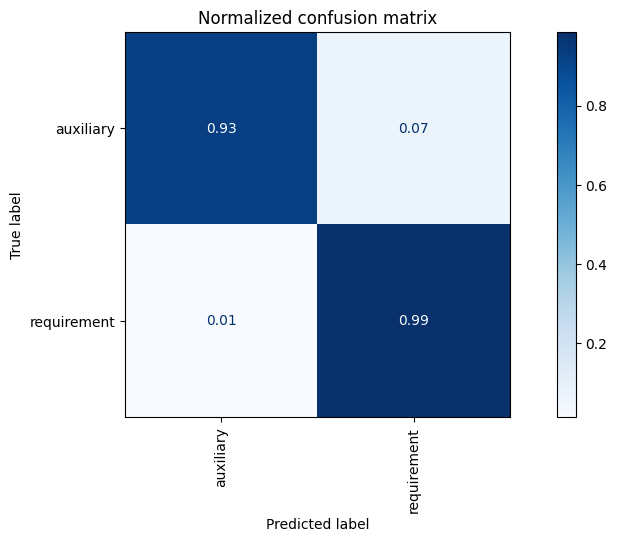

In [19]:
fig, ax = plt.subplots(figsize = (12, 5))
plot_confusion_matrix(y_pred_srs_2, y_true_srs_2, lables, ax)

In [20]:
evaluate(y_true_srs_2, y_pred_srs_2, average = 'macro')

Precision:  0.7940480716427998
Recall:  0.9561598951507209
Recall:  0.8495549326355876


In [21]:
idx = np.where(np.array(y_true_srs_2) != np.array(y_pred_srs_2))[0]
filtered_dataset = srs_2_requirements_hf_predicted.select(idx)
for idx, label, y_pred, y_proba, text in zip(filtered_dataset['id'], filtered_dataset['label'], filtered_dataset['y_pred'], filtered_dataset['y_probas'], filtered_dataset['text']):
    print('ID: ', idx)
    print('True Class: ', label)
    print('Predicted Class: ', y_pred)
    print('Probability: ', y_proba)
    print('Text: ', text)
    print('#' * 10)

ID:  111365
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9966920614242554
Text:  The primary audience of this SRS document will be the development team employed to implement the specified RMOS.
##########
ID:  111438
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9967929720878601
Text:  The payment system should be operable such that it can return information to the RMOS system as to whether payment was successful or failed.
##########
ID:  111446
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9965367317199707
Text:  Users will summon their restaurant menu, which is combined with a system/command menu, using an easy touch gesture, a double-tap on the touch surface, and dismiss it with a similar gesture or by tapping a close button GUI element.
##########
ID:  111447
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9963858127593994
Text:  The GUI will take a small percentage of the table's screen, so

# Loading SRS 3: Blineded for Peer Review

In [22]:
srs_3_path = "./three_real_world_srs/<blinded>/<blinded>_labeled.jsonl"
srs_3_requirements = load_jsonl(srs_3_path)
srs_3_requirements_hf = datasets.Dataset.from_list(srs_3_requirements)

In [23]:
srs_3_requirements_hf_encoded = srs_3_requirements_hf.map(preprocess_function, batched = True)
srs_3_requirements_hf_predicted = srs_3_requirements_hf_encoded.map(forward_pass_with_label, batched = True, batch_size = 8)

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

INFO:tensorflow:Assets written to: ram://be98e299-7a91-4faf-b7dc-1eff1450da54/assets


INFO:tensorflow:Assets written to: ram://be98e299-7a91-4faf-b7dc-1eff1450da54/assets


Map:   0%|          | 0/296 [00:00<?, ? examples/s]

In [24]:
y_true_srs_3 = srs_3_requirements_hf_predicted['label']
y_pred_srs_3 = srs_3_requirements_hf_predicted['y_pred']

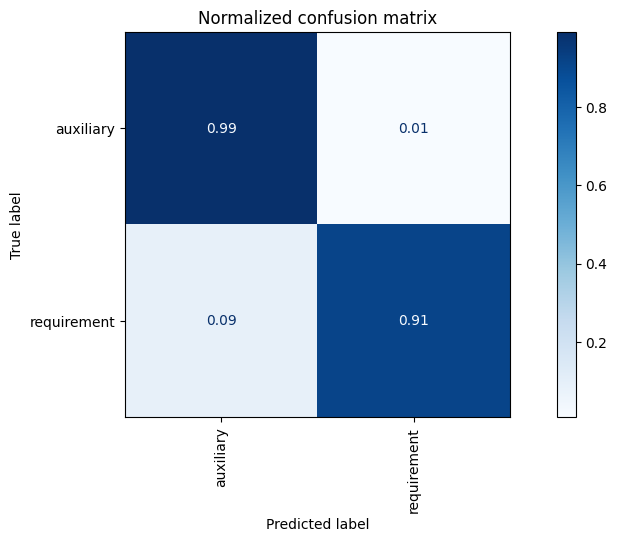

In [25]:
fig, ax = plt.subplots(figsize = (12, 5))
plot_confusion_matrix(y_pred_srs_3, y_true_srs_3, lables, ax)

In [26]:
evaluate(y_true_srs_3, y_pred_srs_3, average = 'macro')

Precision:  0.9648630444544231
Recall:  0.9533114395183361
Recall:  0.9589880012192756


In [27]:
idx = np.where(np.array(y_true_srs_3) != np.array(y_pred_srs_3))[0]
filtered_dataset = srs_3_requirements_hf_predicted.select(idx)
for idx, label, y_pred, y_proba, text in zip(filtered_dataset['id'], filtered_dataset['label'], filtered_dataset['y_pred'], filtered_dataset['y_probas'], filtered_dataset['text']):
    print('ID: ', idx)
    print('True Class: ', label)
    print('Predicted Class: ', y_pred)
    print('Probability: ', y_proba)
    print('Text: ', text)
    print('#' * 10)

ID:  113219
True Class:  auxiliary
Predicted Class:  requirement
Probability:  0.9967143535614014
Text:  The specialists and managers required for this transformation process must be trained early.
##########
ID:  113312
True Class:  requirement
Predicted Class:  auxiliary
Probability:  0.736375093460083
Text:  Basic The Python programming environment shall run in a safe manner, i.e., users shall not be able to execute malicious code. DONE
##########
ID:  113331
True Class:  requirement
Predicted Class:  auxiliary
Probability:  0.9978278279304504
Text:  Basic Functional Integrating the English language beside German only for the software interface is a nice functionality to have.     DONE
##########
ID:  113335
True Class:  requirement
Predicted Class:  auxiliary
Probability:  0.9777881503105164
Text:  The following types of questions must be supported by the test module of the learning platform: Changing the order of the question types, Standard question types, Calculated, calculated 